In [1]:
from pprint import pprint

import dask.dataframe as dd
import networkx as nx
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from graph_reinforcement_learning_using_blockchain_data import config

config.load_dotenv()

2025-03-17 13:17:11.059 | INFO     | graph_reinforcement_learning_using_blockchain_data.config:<module>:11 - PROJ_ROOT path is: /Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data


True

In [2]:
def parse_logs(s: str):
    safe_globals = {
        "__builtins__": {},
        "AttributeDict": lambda d: d,  # return the dict directly
        "HexBytes": lambda x: x,  # return the string argument
    }
    try:
        return eval(s, safe_globals)
    except Exception as e:
        print("Error parsing logs:", e)
        return []

In [3]:
dd_class1 = dd.read_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "arbitrages_with_receipts.csv",
    dtype={
        "end_amount": "object",
        "error": "object",
        "profit_amount": "object",
        "start_amount": "object",
    },
)
dd_class1["receipt"] = dd_class1["receipt"].apply(parse_logs, meta=("logs", "object"))
dd_class1["logs"] = dd_class1["receipt"].apply(lambda x: x["logs"], meta=("logs", "object"))

In [4]:
dd_class0 = dd.read_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "class0_with_receipts.csv"
)

dd_class0["receipt"] = dd_class0["receipt"].apply(parse_logs, meta=("logs", "object"))
dd_class0["logs"] = dd_class0["receipt"].apply(lambda x: x["logs"], meta=("logs", "object"))
dd_class0 = dd_class0[
    dd_class0["logs"].apply(lambda x: x is not None and len(x) > 0, meta=("logs", "bool"))
]

In [5]:
dd_class0.head()

,block_number,transaction_hash,receipt,logs
0,16950601,4d419ef95a879f7d3da5ad7b55289ba88e360d5df7d42b...,{'transactionHash': '0x8e90ecb85b61af368db0154...,[{'blockHash': '0xb6e2ade980aad8c2054ca26beb98...
1,16950601,5f7a16727b0ed026b1656924be454df15951fc3d135093...,{'transactionHash': '0xd83c25449d0766a18945f10...,[{'blockHash': '0xb4bb6a42db43c3a23bef597fceb9...
3,16950601,93211130eb153a9aafe8f6369f747e894750723a51c237...,{'transactionHash': '0x8d3b8e46a66a909643f2bb7...,[{'blockHash': '0x6939a55940dc342800e0f589d9f3...
4,16950601,7e3b9d96c2c7b2e3fd4cf4fb8b8a97f004861d6087fc8d...,{'transactionHash': '0x25908bad48b2353a1da142d...,[{'blockHash': '0x0e8b14acb8a7585b620b340c740e...
5,16950601,0b29f2eb9cd43707a77ec00956299f12b0481b72c92689...,{'transactionHash': '0x78d66376b7f4cd481a31ccd...,[{'blockHash': '0x50cc2fb708d1de23eabb064f3115...


## Features edges

In [6]:
# See notebook 2.01-lte-signatures-arbitrages_with_logs.ipynb
top_class0_signatures = [
    "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef",
    "0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925",
    "0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78be50e062b03a9fffbbad1",
    "0xd78ad95fa46c994b6551d0da85fc275fe613ce37657fb8d5e3d130840159d822",
    "0xe1fffcc4923d04b559f4d29a8bfc6cda04eb5b0d3c460751c2402c5c5cc9109c",
    "0x7fcf532c15f0a6db0bd6d0e038bea71d30d808c7d98cb3bf7268a95bf5081b65",
    "0xc42079f94a6350d7e6235f29174924f928cc2ac818eb64fed8004e115fbcca67",
    "0xe9149e1b5059238baed02fa659dbf4bd932fbcf760a431330df4d934bc942f37",
    "0x9d9af8e38d66c62e2c12f0225249fd9d721c54b83f48d9352c97c6cacdcb6f31",
    "0x17307eab39ab6107e8899845ad3d59bd9653f200f220920489ca2b5937696c31",
]

top_class1_signatures = [
    "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef",
    "0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78be50e062b03a9fffbbad1",
    "0xd78ad95fa46c994b6551d0da85fc275fe613ce37657fb8d5e3d130840159d822",
    "0xc42079f94a6350d7e6235f29174924f928cc2ac818eb64fed8004e115fbcca67",
    "0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925",
    "0x7fcf532c15f0a6db0bd6d0e038bea71d30d808c7d98cb3bf7268a95bf5081b65",
    "0x19b47279256b2a23a1665c810c8d55a1758940ee09377d4f8d26497a3577dc83",
    "0x908fb5ee8f16c6bc9bc3690973819f32a4d4b10188134543c88706e0e1d43378",
    "0xddac40937f35385a34f721af292e5a83fc5b840f722bff57c2fc71adba708c48",
    "0x8201aa3f00000000000000000000000000000000000000000000000000000000",
]

top_signatures = list(set(top_class0_signatures + top_class1_signatures))

In [7]:
def extract_receipt_features(tx_receipt, top_signatures):
    features = {}
    features["transactionHash"] = tx_receipt.get("transactionHash")
    features["blockNumber"] = tx_receipt.get("blockNumber", 0)
    features["gasUsed"] = tx_receipt.get("gasUsed", 0)
    features["cumulativeGasUsed"] = tx_receipt.get("cumulativeGasUsed", 0)
    features["transactionIndex"] = tx_receipt.get("transactionIndex", 0)
    features["effectiveGasPrice"] = tx_receipt.get("effectiveGasPrice", 0)
    features["status"] = tx_receipt.get("status", 0)
    features["fee"] = features["gasUsed"] * features["effectiveGasPrice"]

    features["from"] = tx_receipt.get("from", None)
    features["to"] = tx_receipt.get("to", None)

    logs = tx_receipt.get("logs", [])
    features["num_logs"] = len(logs)

    event_counts = {}
    for log in logs:
        topics = log.get("topics", [])
        if topics:
            sig = topics[0].hex() if hasattr(topics[0], "hex") else str(topics[0])
            event_counts[sig] = event_counts.get(sig, 0) + 1

    for sig in top_signatures:
        features[f"dummy_{sig[:10]}"] = 1 if sig in event_counts else 0

    return features

In [8]:
dd_features_class0 = dd_class0["receipt"].apply(
    lambda row: extract_receipt_features(row, top_signatures),
    axis=0,
    meta=("features", "object"),
)
dd_features_class1 = dd_class1["receipt"].apply(
    lambda row: extract_receipt_features(row, top_signatures),
    axis=0,
    meta=("features", "object"),
)

In [9]:
features_class0 = dd_features_class0.compute()
features_class1 = dd_features_class1.compute()

In [10]:
df_features_class0 = pd.DataFrame(list(features_class0))
df_features_class1 = pd.DataFrame(list(features_class1))

In [11]:
df_features_class0["label"] = 0
df_features_class1["label"] = 1

In [12]:
df_features_edges = pd.concat([df_features_class0, df_features_class1])
df_features_edges = df_features_edges.drop_duplicates(subset="transactionHash")

In [14]:
df_features_edges.describe()

,blockNumber,gasUsed,cumulativeGasUsed,transactionIndex,effectiveGasPrice,status,fee,num_logs,dummy_0xc42079f9,dummy_0xe1fffcc4,...,dummy_0x908fb5ee,dummy_0x9d9af8e3,dummy_0xddac4093,dummy_0x19b47279,dummy_0x17307eab,dummy_0x8201aa3f,dummy_0x7fcf532c,dummy_0xd78ad95f,dummy_0xddf252ad,label
count,1.841320e+05,1.841320e+05,1.841320e+05,184132.000000,1.841320e+05,184132.000000,1.841320e+05,184132.000000,184132.000000,184132.000000,...,184132.000000,184132.000000,184132.000000,184132.000000,184132.000000,184132.000000,184132.000000,184132.000000,184132.000000,184132.000000
mean,1.716620e+07,1.863430e+05,4.987966e+06,47.411107,8.884334e+10,0.994336,1.761888e+16,7.021425,0.466649,0.050181,...,0.019491,0.012502,0.003150,0.025726,0.018747,0.015999,0.062477,0.600319,0.870148,0.594590
std,1.710251e+05,2.776833e+05,5.612807e+06,60.810254,3.361615e+11,0.075049,6.831637e+16,8.466739,0.498888,0.218320,...,0.138245,0.111111,0.056036,0.158317,0.135632,0.125473,0.242020,0.489834,0.336142,0.490973
min,1.695060e+07,2.211100e+04,2.863000e+04,0.000000,1.152221e+10,0.000000,3.397166e+14,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.700772e+07,1.158430e+05,9.907772e+05,5.000000,2.430024e+10,1.000000,2.915748e+15,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.713812e+07,1.548815e+05,2.583603e+06,17.000000,3.711871e+10,1.000000,6.336828e+15,6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,1.730604e+07,2.187760e+05,7.383776e+06,79.000000,7.120429e+10,1.000000,1.399769e+16,9.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.751777e+07,2.402678e+07,2.999378e+07,831.000000,3.810702e+13,1.000000,7.302631e+18,960.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
df_features_edges.head()

,transactionHash,blockNumber,gasUsed,cumulativeGasUsed,transactionIndex,effectiveGasPrice,status,fee,from,to,...,dummy_0x908fb5ee,dummy_0x9d9af8e3,dummy_0xddac4093,dummy_0x19b47279,dummy_0x17307eab,dummy_0x8201aa3f,dummy_0x7fcf532c,dummy_0xd78ad95f,dummy_0xddf252ad,label
0,0x8e90ecb85b61af368db0154830453552f0c27e0e1812...,17005294,153529,10750253,111,19150328915,1,2940130847991035,0x832aC338d06f5A438f3340B724c08C44e744e9c2,0x00000000000001ad428e4906aE43D8F9852d0dD6,...,0,1,0,0,0,0,0,0,1,0
1,0xd83c25449d0766a18945f10aff7912f2ff492f0234a8...,16962424,123497,229900,1,139502435999,1,17228132338568503,0x080086911D8c78008800FAE75871a657b77d0082,0x0000E0Ca771e21bD00057F54A68C30D400000000,...,0,0,0,0,0,0,0,1,1,0
2,0x8d3b8e46a66a909643f2bb7497b18c954fc22fa5bd5c...,16972733,46817,14885776,165,18825121161,1,881335697394537,0xCA8ba7d3f798d1872A8C05c5358a1b24a4d3Ac64,0x2b591e99afE9f32eAA6214f7B7629768c40Eeb39,...,0,0,0,0,0,0,0,0,1,0
3,0x25908bad48b2353a1da142da6f0a19c015dfbac5245f...,17028487,32215,3160909,48,19660583885,1,633365709855275,0x8FEf490D614fCe8B93Bd6F28835dD35a8B3229a9,0xBA50933C268F567BDC86E1aC131BE072C6B0b71a,...,0,0,0,0,0,0,0,0,1,0
4,0x78d66376b7f4cd481a31ccd9b4c1440259695cb2e5d2...,17067044,153886,9279317,110,45282851253,1,6968396847919158,0xc94893b6D1CC1d7ce09Fec6abC9B5949A903d2C9,0xEf1c6E67703c7BD7107eed8303Fbe6EC2554BF6B,...,0,0,0,0,0,0,0,0,1,0


In [16]:
# nan values
df_features_edges.isna().sum()

transactionHash       0
blockNumber           0
gasUsed               0
cumulativeGasUsed     0
transactionIndex      0
effectiveGasPrice     0
status                0
fee                   0
from                  0
to                   77
num_logs              0
dummy_0xc42079f9      0
dummy_0xe1fffcc4      0
dummy_0x8c5be1e5      0
dummy_0xe9149e1b      0
dummy_0x1c411e9a      0
dummy_0x908fb5ee      0
dummy_0x9d9af8e3      0
dummy_0xddac4093      0
dummy_0x19b47279      0
dummy_0x17307eab      0
dummy_0x8201aa3f      0
dummy_0x7fcf532c      0
dummy_0xd78ad95f      0
dummy_0xddf252ad      0
label                 0
dtype: int64

In [13]:
df_features_edges.dropna(inplace=True)

In [14]:
len(df_features_edges)

184055

In [15]:
df_features_edges["blockNumber"].max() - df_features_edges["blockNumber"].min()

567172

In [16]:
def plot_hist(df, label_name):
    sns.set(style="whitegrid")

    plt.figure(figsize=(8, 6))
    ax = sns.histplot(df[label_name], bins=2, discrete=True)

    for p in ax.patches:
        ax.annotate(
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
        )

    ax.set_xticks([0, 1])
    ax.set_xlabel("Class Label")
    ax.set_ylabel("Count")
    ax.set_title("Histogram of Class Labels")

    plt.show()

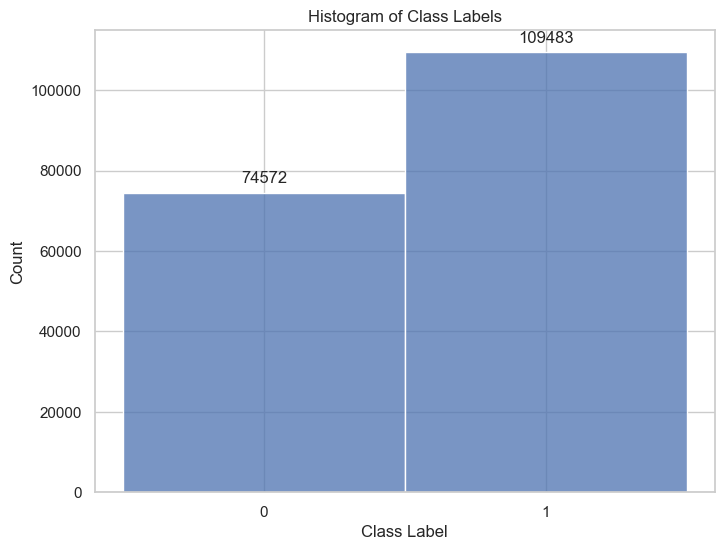

In [17]:
plot_hist(df_features_edges, "label")

In [22]:
# df_features_edges.to_csv(
#     config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_edges_without_0logs.csv",
#     index=False,
# )

## Features nodes

In [23]:
dummy_cols = [col for col in df_features_edges.columns if col.startswith("dummy_")]

agg_dict = {
    "gasUsed": ["mean"],
    "cumulativeGasUsed": ["mean"],
    "transactionIndex": ["min", "max", "mean"],
    "effectiveGasPrice": ["mean", "max"],
    "status": "mean",  # proportion of successful transactions
    "fee": ["mean"],
    "label": "max",  # If any transaction is arbitrage (1), then account is arbitrage
    "num_logs": ["min", "max", "mean"],
}

for col in dummy_cols:
    agg_dict[col] = "mean"

df_accounts = df_features_edges.groupby("from").agg(agg_dict)

df_accounts.columns = [
    "_".join(col).strip() if isinstance(col, tuple) else col for col in df_accounts.columns.values
]

df_accounts = df_accounts.rename(
    columns={
        "label_max": "account_label",
    }
)

df_accounts = df_accounts.reset_index().rename(columns={"from": "account"})

In [24]:
df_accounts.head()

,account,gasUsed_mean,cumulativeGasUsed_mean,transactionIndex_min,transactionIndex_max,transactionIndex_mean,effectiveGasPrice_mean,effectiveGasPrice_max,status_mean,fee_mean,...,dummy_0x1c411e9a_mean,dummy_0x908fb5ee_mean,dummy_0x9d9af8e3_mean,dummy_0xddac4093_mean,dummy_0x19b47279_mean,dummy_0x17307eab_mean,dummy_0x8201aa3f_mean,dummy_0x7fcf532c_mean,dummy_0xd78ad95f_mean,dummy_0xddf252ad_mean
0,0x00000000000124d994209fbB955E0217B5C2ECA1,153953.333333,2.349512e+06,3,39,18.833333,4.240266e+10,62912040686,1.0,6.261262e+15,...,0.500000,0.0,0.0,0.0,0.000000,0.0,0.0,0.5,0.500000,1.0
1,0x0000000000055772357E58581A2A2C5C6D9E8F64,184513.083333,2.028324e+06,0,94,12.666667,4.816098e+10,809819701570,1.0,9.001021e+15,...,0.510417,0.0,0.0,0.0,0.520833,0.0,0.0,0.0,0.510417,1.0
2,0x00000000000FFE26043F4C963A16612f8410A881,132305.000000,1.212181e+07,147,147,147.000000,2.896867e+10,28968672309,1.0,3.832700e+15,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0
3,0x0000000000d14562212733C7DA3923DFe2613603,101080.000000,2.170596e+07,232,232,232.000000,2.640542e+10,26405422524,1.0,2.669060e+15,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0
4,0x0000000007cB415122b0049a88bf24841260050e,46563.000000,1.612438e+07,166,166,166.000000,1.782762e+10,17827622923,1.0,8.301076e+14,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [25]:
len(df_accounts)

55161

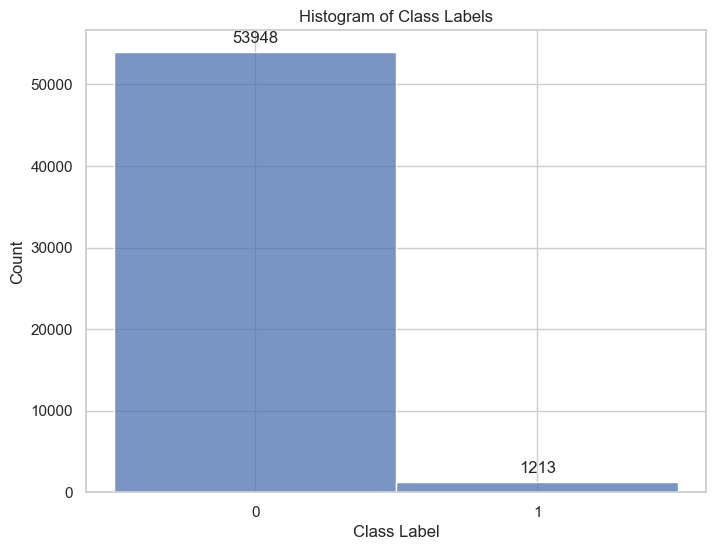

In [26]:
plot_hist(df_accounts, "account_label")

In [27]:
# df_accounts.to_csv(
#     config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_nodes_improved.csv",
#     index=False,
# )

## Graph Features over all transactions

In [28]:
def add_graph_features(df):
    df_block = df.copy()

    G = nx.from_pandas_edgelist(df_block, source="from", target="to", create_using=nx.DiGraph())
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())

    G_undirected = G.to_undirected()
    clustering = nx.clustering(G_undirected)

    def common_neighbors_count(u, v):
        return len(list(nx.common_neighbors(G_undirected, u, v)))

    df_block["from_in_degree"] = df_block["from"].apply(lambda x: in_degrees.get(x, 0))
    df_block["from_out_degree"] = df_block["from"].apply(lambda x: out_degrees.get(x, 0))
    df_block["to_in_degree"] = df_block["to"].apply(lambda x: in_degrees.get(x, 0))
    df_block["to_out_degree"] = df_block["to"].apply(lambda x: out_degrees.get(x, 0))
    df_block["common_neighbors"] = df_block.apply(
        lambda row: common_neighbors_count(row["from"], row["to"]), axis=1
    )
    df_block["from_clustering"] = df_block["from"].apply(lambda x: clustering.get(x, 0))
    df_block["to_clustering"] = df_block["to"].apply(lambda x: clustering.get(x, 0))

    return df_block

In [29]:
df_features_edges_graph = add_graph_features(df_features_edges)

In [30]:
print(df_features_edges_graph.head())

                                     transactionHash  blockNumber  gasUsed  \
0  0x8e90ecb85b61af368db0154830453552f0c27e0e1812...     17005294   153529   
1  0xd83c25449d0766a18945f10aff7912f2ff492f0234a8...     16962424   123497   
2  0x8d3b8e46a66a909643f2bb7497b18c954fc22fa5bd5c...     16972733    46817   
3  0x25908bad48b2353a1da142da6f0a19c015dfbac5245f...     17028487    32215   
4  0x78d66376b7f4cd481a31ccd9b4c1440259695cb2e5d2...     17067044   153886   

   cumulativeGasUsed  transactionIndex  effectiveGasPrice  status  \
0           10750253               111        19150328915       1   
1             229900                 1       139502435999       1   
2           14885776               165        18825121161       1   
3            3160909                48        19660583885       1   
4            9279317               110        45282851253       1   

                 fee                                        from  \
0   2940130847991035  0x832aC338d06f5A438f3340B7

In [31]:
df_features_edges_graph.to_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_edges_graph.csv", index=False
)

## Graph Features per block

In [34]:
df_edge_features_by_block = (
    df_features_edges.groupby("blockNumber").apply(add_graph_features).reset_index(drop=True)
)

/var/folders/zd/5rj11nhj5h98j5kmp_lp5k5w0000gn/T/ipykernel_63302/588891841.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features_edges.groupby("blockNumber").apply(add_graph_features).reset_index(drop=True)


In [35]:
print(df_edge_features_by_block.head())

                                     transactionHash  blockNumber  gasUsed  \
0  0xaf94feedf4330e4a5c2bf084d2e6739652287dbfc6e0...     16950601   254032   
1  0x07d24a0c6b2837c5731ad659f62c59b935b2195e70dc...     16950601   157316   
2  0x829e063b46be14c2aee305bd47b9a8a0b39e45188f7b...     16950601    62833   
3  0xecc47846dfe260279e97af043ca77863801bca2340db...     16950601   161027   
4  0x7e3b9d96c2c7b2e3fd4cf4fb8b8a97f004861d6087fc...     16950601    48537   

   cumulativeGasUsed  transactionIndex  effectiveGasPrice  status  \
0            2564577                16        22568554601       1   
1            2135061                12        50000000000       1   
2            5225102                71        19360969611       1   
3            4143764                47        19860969611       1   
4           10131517               140        22000000000       1   

                fee                                        from  \
0  5733135062401232  0xC6c7565644EA1893ad29182F7B

In [36]:
df_edge_features_by_block.to_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_edges_graph_by_block.csv",
    index=False,
)

## Graph Metrics

In [99]:
def compute_graph_metrics(G):
    simple_G = nx.DiGraph(G)

    density = nx.density(simple_G)

    avg_degree = (
        sum(dict(simple_G.degree()).values()) / simple_G.number_of_nodes()
        if simple_G.number_of_nodes() > 0
        else 0
    )

    clustering_coeff = nx.average_clustering(simple_G.to_undirected())

    components = list(nx.weakly_connected_components(simple_G))
    largest_component_size = max((len(c) for c in components), default=0)
    num_isolated_nodes = len(list(nx.isolates(simple_G)))

    degree_distribution = {}
    for node, degree in simple_G.degree():
        degree_distribution[degree] = degree_distribution.get(degree, 0) + 1

    return {
        "size": simple_G.number_of_nodes(),
        "density": density,
        "average_degree": avg_degree,
        "clustering_coefficient": clustering_coeff,
        "largest_component_size": largest_component_size,
        "num_isolated_nodes": num_isolated_nodes,
        "degree_distribution": degree_distribution,
    }

In [100]:
metrics = compute_graph_metrics(G)

In [101]:
pprint(metrics)

{'average_degree': 1.7626387725644634,
 'clustering_coefficient': 0.0008382579089858824,
 'degree_distribution': {1: 102060,
                         2: 6378,
                         3: 1453,
                         4: 651,
                         5: 310,
                         6: 212,
                         7: 155,
                         8: 105,
                         9: 85,
                         10: 74,
                         11: 55,
                         12: 45,
                         13: 43,
                         14: 42,
                         15: 28,
                         16: 32,
                         17: 33,
                         18: 22,
                         19: 21,
                         20: 16,
                         21: 21,
                         22: 17,
                         23: 10,
                         24: 9,
                         25: 9,
                         26: 12,
                         27: 10,
                  

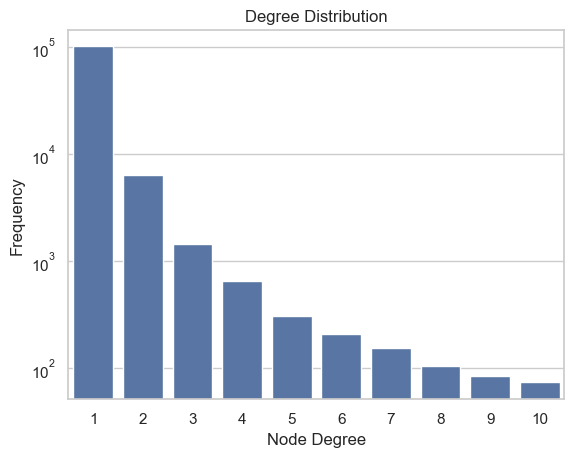

In [102]:
top_degrees = sorted(metrics["degree_distribution"].items(), key=lambda x: x[1], reverse=True)[:10]
sns.barplot(x=[d[0] for d in top_degrees], y=[d[1] for d in top_degrees])
plt.yscale("log")
plt.xlabel("Node Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.show()